# Movie Reccomendation System - Hunter Beesley

### Project Description

For this project, I wanted to create a program that will be able to reccomend movies to users that they have not watched yet. I want the program to reccomend movies that are similar to movies that the user has rated well in the past. In order to do so, I can use collaborative filtering, which is where the program will find other similar users who have rated items similar to the input user, and will then suggest items to the input user that the similar users have rated highly. 

###  Libraries

I am starting this project by importing libraries that are frequently used in most data science projects: Numpy, Pandas, and Matplotlib. I am using Numpy and Pandas to create and manipulate arrays and dataframes. I will use Matplotlib to create visualizations for my data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Importing Data

The data that I am using for this project is retrieved from the MovieLens 20M dataset, which can be found at https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset. This dataset contains two csv files, one of which has data for movies (titles, genres, and movie IDs) and the other of which has data for ratings (ratings {out of 5}, user IDs, and timestamps).

In [2]:
movies = pd.read_csv("archive-2/movie.csv")
ratings = pd.read_csv("archive-2/rating.csv")

### Understanding the Data

Before I start preprocessing the data, I will first look at the head of the movies and ratings dataframes to get a better understanding of how the data is structured.

In [3]:
print("Movie Data:\n",movies.head())
print("Ratings Data:\n",ratings.head())

Movie Data:
    movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
Ratings Data:
    userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


Here, we can see that each movie in the movies dataframe has an ID (which is an integer), a title (which is a string), and a list of genres (which is also a string). In the ratings dataframe, each rating has an associated userID (integer), movieId(integer), rating (float), and timestamp (string). 

To make movie reccomendations to a user, I will be relying on other ratings that other similar users made. I will not be making reccomendations based on how similar the movies themselves are. Therefore, I will not need the genres column in the movies dataframe. I won't be making reccomendations based on time either, so I will drop the timestamp column from the ratings dataframe. 

In [4]:
del(movies['genres'])
del(ratings['timestamp'])
print("Movie Data:\n",movies.head())
print("Ratings Data:\n",ratings.head())

Movie Data:
    movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)
Ratings Data:
    userId  movieId  rating
0       1        2     3.5
1       1       29     3.5
2       1       32     3.5
3       1       47     3.5
4       1       50     3.5


We can take a look at the number of rows and columns in each of our dataframe:

In [5]:
print("Movies dataframe shape: ", movies.shape)
print("Ratings dataframe shape: ", ratings.shape)

Movies dataframe shape:  (27278, 2)
Ratings dataframe shape:  (20000263, 3)


The movies dataframe has a lot more observations than the movie dataframe. The reason for this is because there are multiple users who have left ratings for the same movie.

### Visualizing the Data

To understand the data even further, we can look at a few visualizations. Let's start by looking at the distribution of user ratings:

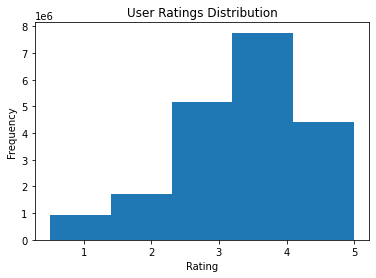

In [6]:
rating_dist = plt.hist(ratings['rating'], bins = 5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("User Ratings Distribution")
plt.show()

We can also group the movies in order to visualize the distribution of the mean score of movies:

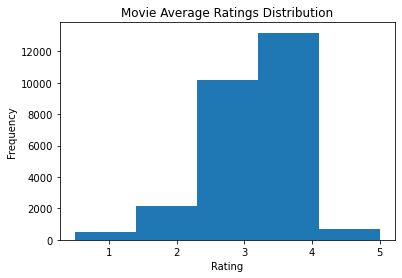

In [7]:
mean_rating_mv = ratings.groupby("movieId")["rating"].mean().reset_index(name = "rating")
mv_ratings_dist = plt.hist(mean_rating_mv["rating"], bins = 5)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Movie Average Ratings Distribution")
plt.show()

We can look at the most rated movies in the dataset:

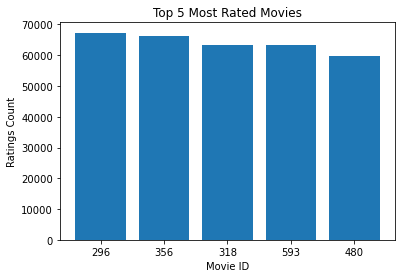

In [8]:
ratings_by_mv = ratings.groupby("movieId")["rating"].count().reset_index(name = "Number of ratings").sort_values(by="Number of ratings", ascending = False)
top_5 = ratings_by_mv.reset_index()[0:5]
top_5['movieId'] = top_5['movieId'].astype('string')
plt.bar(x=top_5['movieId'], height=top_5['Number of ratings'])
plt.xlabel("Movie ID")
plt.ylabel("Ratings Count")
plt.title("Top 5 Most Rated Movies")
plt.show()

And we can look at the correlation between the number of ratings a movie has and it's average rating:

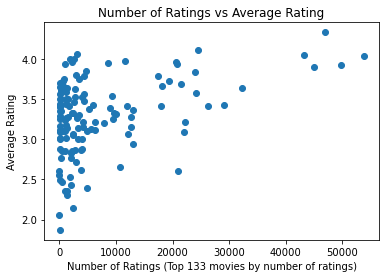

In [9]:
ratings_score = ratings.groupby('movieId') \
       .agg({'movieId':'size', 'rating':'mean'}) \
       .rename(columns={'movieId':'count','rating':'mean_rating'}) \
       .reset_index()
ratings_score.sort_values(by="count", ascending = False)
num = len(ratings_score)//200
ratings_score = ratings_score[:num]
plt.scatter(ratings_score['count'], ratings_score['mean_rating'])
plt.xlabel("Number of Ratings (Top " + str(num) + " movies by number of ratings)")
plt.ylabel("Average Rating")
plt.title("Number of Ratings vs Average Rating")
plt.show()

### Preprocessing

For this project, I will need to reduce the amount of data that is in my ratings dataset for memory purposes. As you will see later, I will use a sparse matrix to create a representation of my data that requires less memory, but I will still need to take less observations here in order to call certain functions on my dataframe. 

Here, I will be selecting 2% of the dataset (roughly 400,000 observations) for further analysis. First, I sort the ratings data in descending order based on the number of ratings associated with the userId (essentially, movie ratings made by a user with more total ratings will appear first).

In [10]:
user_counts = ratings['userId'].value_counts()
ratings = ratings.loc[ratings['userId'].isin(user_counts.index)].sort_values(by='userId', key=lambda x: x.map(user_counts), ascending=False)
ratings = ratings[:(len(ratings)//50)]
print("Ratings dataframe shape: ",ratings.shape)

Ratings dataframe shape:  (400005, 3)


Now, I will create a new dataframe called ratings_user. In this dataframe, each row will correspond to a user and each column will correspond to a movie. If a user has rated a certain movie, the cell that corresponds to that user and movie will be filled with the user's rating for the movie. If they have not rated it, the cell will be filled with 0. This dataframe is necessary for calculating the similarities between users.

In [11]:
ratings_user = ratings[['userId', 'movieId', 'rating']].pivot(index='userId', columns='movieId', values = 'rating').fillna(0)
ratings_user.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,130746,130804,130828,130842,130850,130852,130900,131017,131172,131180
userId,,,,,,,,,,,,,,,,,,,,,
903,4.0,4.0,2.0,2.0,3.0,4.0,3.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2261,3.0,3.5,2.5,0.0,1.0,3.5,1.5,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3907,4.0,2.5,0.0,0.0,0.0,4.0,2.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4222,5.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4358,5.0,3.0,1.0,0.0,0.0,5.0,3.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Because of the amount of movies in this dataset, most rows in the ratings_user dataframe will be filled with 0's since the users haven't watched most of the movies. This creates a lot of wasted space and memory. To save memory, I will convert the ratings_user dataframe into a sparse matrix and store the result in spr_rat. I do this using the scipy library. A sparse matrix consists of pairs of indices and values. The indices represent the row and column in the initial matrix where there is a nonzero entry, which is represented by the value.   

In [12]:
from scipy import sparse
spr_rat = sparse.csr_matrix(ratings_user)

Before I start calculating the similarities between users, I must first normalize the data. The reason I need to do this is because each person will have their different rating scales, which means they might give a different rating for a movie that they consider to be good than other users who also think that movie is good. In order to calculate the similarities between users based on their ratings, the rating should be standardized. To do this, I can use sklearn to normalize the ratings. I will store the normalized sparse matrix in rat_norm.

In [13]:
from sklearn.preprocessing import normalize
rat_norm = normalize(spr_rat, norm='l1', axis=1)

### Calculating Similarity

Now that I have finished preprocessing the data, I can calculate the similarities between users based on their ratings. 

The method that I will be using to calculate the similarity is cosine similarity. Here is a detailed description of cosine similarity: https://en.wikipedia.org/wiki/Cosine_similarity. To calculate cosine similarity, I will be using the method provided by sklearn and I'll store the results as a sparse matrix in user_sim.

In [14]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(rat_norm, dense_output = False)

For each user, I will now take their similarities and select the most similar users. In the code below, I select the 4 most similar users for each user (if there are 4 similar users). I create a list of their ID's and append the list to similar_users. At the end, I print out the first 5 similar user lists for reference.

In [15]:
similar_users = []
row_start = user_sim.indptr[:-1]
row_end = user_sim.indptr[1:]
for s,e in zip(row_start, row_end):
    row_elements = 4 if 4 < (e - s) else (e - s)
    similar_users.append(user_sim.indices[s + np.argpartition(user_sim.data[s:e], -row_elements)[-row_elements:]])
similar_users[0:5]

[array([81, 78, 74,  0], dtype=int32),
 array([26, 79,  1, 86], dtype=int32),
 array([ 22,  19, 113,   2], dtype=int32),
 array([73,  6,  3, 80], dtype=int32),
 array([99, 30, 60,  4], dtype=int32)]

In these lists, some users have themself listed as a similar user. To prevent this, I loop through the list and remove the user from it's own similarity list (if necessary). I now print out the first 5 user similarity lists for reference against the previous output.

In [16]:
for i in range(0, len(similar_users)):
    similar_users[i] = similar_users[i][similar_users[i] != i]
similar_users[0:5]

[array([81, 78, 74], dtype=int32),
 array([26, 79, 86], dtype=int32),
 array([ 22,  19, 113], dtype=int32),
 array([73,  6, 80], dtype=int32),
 array([99, 30, 60], dtype=int32)]

I still need to modify these lists because currently, the list entries correpsond to indices of the users rather than their userId values. I loop through the list and add a dictionary entry to similar_user_id, where the key is a userId and the value is a list of userIds that correspond to the similar users.

In [17]:
similar_user_id = {}
for key, val in enumerate(similar_users):
    for i in range(len(val)):
        val[i] = ratings_user.index[val[i]]
    similar_user_id[ratings_user.index[key]] = val

### Creating Reccomendations

Now that I have calculated the most similar users to each user, I can start making movie reccomendations to users based on the movies that similar users like. I create a function that takes in a user_id as an argument. For this user, it will collect the list of similar users. Then, for each similar user, the function will find the movies rated by that user, take the ones with a rating of 3.5 or above, and will randomly sample 3 of them and append them to the list of reccomendations. At the end, the function returns the list of movie reccomendations.

In [18]:
def reccomend_movies(user_id):
    similars = similar_user_id[user_id]
    reccomend = []
    for usr in similars:
        movie_list = ratings[(ratings['userId'] == usr)&(ratings['userId'] != user_id)]
        movies_good = movie_list[(movie_list['rating'] >= 3.5)].sample(n=3)
        reccomend.append(movies[(movies['movieId'].isin(movies_good['movieId']))]['title'].values.tolist())
    return reccomend

Here is a working example of the function providing reccomendations to a user:

In [19]:
print("Reccomendations for user " + str(ratings_user.index[0]) + ":\n")
for x in reccomend_movies(ratings_user.index[0]):
        for el in x:
            print(el)

Reccomendations for user 903:

Paper, The (1994)
Cabaret (1972)
Vanishing, The (Spoorloos) (1988)
While You Were Sleeping (1995)
Wild Things (1998)
Conformist, The (Conformista, Il) (1970)
Little Buddha (1993)
12 Angry Men (1957)
Chariots of Fire (1981)


### Final Thoughts

I really enjoyed working on this project. Reccomendation systems seem really interesting to me, but this is my first time actually getting to implement one. Some of the concepts were challenging to grasp, but in the end I was able to create a system that produces personalized reccomendations for each user.

I am hoping to do more projects related to reccomendation systems in the future. Next time I will probably want to explore content based filtering rather than collaborative filtering, and then maybe I could possibly find a way to get even better reccomendations by combining the two.